In [1]:
import os
import sys
import bisect

## Approach 1

The search in this approach is as done by calculating the edit distance from the target word to each word in the dictionary. Accept the words with edit distance = 1. Once we found the number of words that we want with edit distance below the threshold define, we stop the search.

The loop over the whole set of words may end before finding the needed number of similar words. So, this approach can not gaurantee that the requested number of similar words will be returned. However, there are 2 solutions to this problem.
    
    1 - there is sim_threshold parameter that can be changed to a bigger threshold allowing more words to be included in the solution.
    
    2- Solution 1 may favor word with bigger edit distance  over another word with lower edit distances just because it came first in the word-set. Therefore, using get_full_nearest will iteratively find the nearest words with edit distance 1. If they are not enough, it will search for words with edit distance 2, and so on.


**Find analysis of the tradeoff between search quality and search speed of the 2 methods of search below**



####  complexity
For the edit distance funcntion:
     both time and mempry complexity -> is O(L_a*L_b); where a and b are the lengths of of the two strings passed to edit distance function.
  
     - add: According to set definition, the add operation time complexity is O(1).

     - get_nearest:
            - worse case: we have to traverse all the words in the dictionary. the time complexity is O(n*d); where n is the total number of words.
    
     -get_full_nearest:
            - time complexity is O(n*m*d); where n is the total number of words, and m is the total number of search loops each with different threshold, 

In [83]:
class SpellChecker:
    def __init__(self, dict_path):
        self.dict_path  = dict_path
        self.word_set = self.load_dict(self.dict_path)
    
    
    def store_words(self, word_list):
        word_set = set()
        
        for word in word_list:
            word_set.add(word)
        return word_set
    
    def load_dict(self, dict_path):
        word_list = []
        with open(dict_path,errors="ignore") as file:
            word_list = file.read().splitlines()
            
        return self.store_words(word_list)
    
    def add(self, word):
        self.word_set.put(word)
    
    def candidates(self, word, nearest, sim_threshold): 
        """"
         - loop over all the words we have. if the distance from that word and the target word is less than some thershold,
           add this word to the solution.
           
         params:
             word: the word to get similar words for
             nearest: the number of similar words to be returned
             sim_threshold: to select words with similarity under this threshold only
        returns:
            answer: list of similar words, its length is at most equal to nearest.
        """
        answer = []
        i = 1
        
        for w in self.word_set:
            if self.edit_distance(word, w) <= sim_threshold:
                if word not in answer:
                    answer.append(w)
                    if len(answer) == nearest:
                        return answer

            
        return answer
    

    
    def edit_distance(self, a, b):
        m = len(a)
        n = len(b)
        dp = [[0 for x in range(n + 1)] for x in range(m + 1)]

        for i in range(m + 1):
            for j in range(n + 1):

                if i == 0:
                    dp[i][j] = j  

                elif j == 0:
                    dp[i][j] = i    

                elif a[i-1] == b[j-1]:
                    dp[i][j] = dp[i-1][j-1]

                else:
                    dp[i][j] = 1 + min(dp[i][j-1],        
                                       dp[i-1][j],        
                                       dp[i-1][j-1])  

        return dp[m][n]

    
    def get_nearest(self, word, nearest = 4, sim_threshold = 1):
            if word in self.word_set:
                return word
            return self.candidates(word, nearest, sim_threshold)
        
    def get_full_nearest(self, word, nearest = 4, limit = 3):
            if word in self.word_set:
                return word
            
            answer = []
            i = 1
            while(i < limit):
                answer  = answer +  self.candidates(word, nearest, sim_threshold = i)
                if len(answer) >= nearest:
                    return answer[:nearest]
                i += 1
                

In [84]:
sc = SpellChecker('./dictionary.txt')

In [93]:
%%time
nearest  = sc.get_nearest('aas', nearest = 4)
nearest

Wall time: 656 ms


['pas', 'gas', 'bas', 'las']

In [85]:
%%time
nearest  = sc.get_nearest('aas', nearest = 50)
len(nearest), nearest[-10:]

Wall time: 2.79 s


(17, ['vas', 'haas', 'ass', 'was', 'has', 'ras', 'cas', 'fas', 'aaa', 'alas'])

Using get nearest without threshold will return at most all the words with edit distance 1. for the word 'aas', there are only other 17 words with edit distance 1. we will use this configuration to analyze the methods.

####  get_nearest

In [89]:
%%time
nearest  = sc.get_nearest('aas', nearest = 30, sim_threshold = 3)
len(nearest), nearest

Wall time: 27 ms


(30,
 ['fo',
  'clasp',
  'dim',
  'maims',
  'sans',
  'yeast',
  'hark',
  'wale',
  'msc',
  'dfc',
  'salad',
  'bank',
  'cagy',
  'ipso',
  'rani',
  'wall',
  'psi',
  'tuns',
  'gist',
  'wages',
  'laves',
  'pails',
  'axis',
  'mao',
  'toms',
  'doss',
  'lobs',
  'real',
  'sow',
  'axle'])

When we allowed threshold equal to 3, the time improved from 2 seconds to 27 ms. However, some words with edit distance more than 2 are included. Meanwhile, there are enough words with edit distance = 2 to complete 50 nearest. So, in this case, this is not the best solution.

#### solution 2

In [90]:
%%time
nearest  = sc.get_full_nearest('aas', nearest = 30)
len(nearest), nearest

Wall time: 2.58 s


(30,
 ['pas',
  'gas',
  'bas',
  'las',
  'as',
  'aa',
  'ads',
  'vas',
  'haas',
  'ass',
  'was',
  'has',
  'ras',
  'cas',
  'fas',
  'aaa',
  'alas',
  'sans',
  'axis',
  'mao',
  'rase',
  'nay',
  'paz',
  'la',
  'gam',
  'hats',
  'bad',
  'ages',
  'pas',
  'lads'])

However this methods took roughly 3 seconds, more similar words are returned.

Note: This tradeoff should be more visible with higher number of nearest words required.

## Aproach 2

#### Data structure: HashSet.
The Hashset is used to store the words found in the dictionary. Hashset do not preserve specific sorting of the words. The searching is based upon generating the possible words that we expect to be in the HashSet, then check if they are in the HashSet.


add:
    - According to HashSet definition, the add operation time complexity is O(1). 
    
get_nearest:
    - Worst case we will need to consume all the allowed number of edits. The default is 2 edits, it can be changed by the user. So we will denote the search limit by m.
    - This is a bit tricky, but for simplicity (m=2; proved below to be sufficient if dictionary is big enough)
                - 2 loops: 1st loop of length  =  the number of words in the output of->  edit_n(word,1)
                           2nd loop of length  =  the number of words in the output of -> O( edit_n(word,2) ) -> from the below plots, this loop will dominate over the first loop.
               
               + the complexity of the edit_n(word,2) itself.


In [228]:
class SpellChecker_2:
    def __init__(self, dict_path):
        self.dict_path  = dict_path
        self.word_set = self.load_dict(self.dict_path)
    
    
    def store_words(self, word_list):
        word_set = set()
        
        for word in word_list:
            word_set.add(word)
        return word_set
    
    def load_dict(self, dict_path):
        word_list = []
        with open(dict_path,errors="ignore") as file:
            word_list = file.read().splitlines()
            
        return self.store_words(word_list)
    
    def add(self, word):
        self.word_set.put(word)
    
    def candidates(self, word, nearest, search_limit): 
        """"
         - Generate all words that are n edits from word until you find four of them in our dictionary.
         - n starts from 1 and incremented if the answer is not constructed so far
         - n is limited to 'search_limit', as if in the worst case this method might get into finite loop
        
         params:
             word: the word to get similar words for
             nearest: the number of similar words to be returned
             search_limit: limit the search for similar words up to number of edits equal to search_limit
        returns:
            answer: list of similar words, its length is at most equal to nearest.
        """
        answer = []
        i = 1
        
        while(i <= search_limit): 
            candidate_list = self.edits_n(word, i)
            for candidate_word in candidate_list:
                if (candidate_word in self.word_set) & (candidate_word not in answer):
                    answer.append(candidate_word)
                    if len(answer) == nearest:
                        return answer
            i += 1

            
        return answer


    def edits_1(self, word):
        """
        All edits that are one edit away from `word`.
        reference: http://norvig.com/spell-correct.html
        """
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        
        deletes    = [L + R[1:]               for L, R in splits if R]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]

        return set(deletes + replaces + inserts)
    

    def edits_n(self, word, n): 
        "All edits that are n edits away from `word`."
        edits_i = self.edits_1(word)
        
        for i in range(1,n):
            edits_i = (e2 for e1 in edits_i for e2 in self.edits_1(e1))
            
        return edits_i

    
    def get_nearest(self, word, nearest = 4, search_limit = 2):
            if word in self.word_set:
                return word
            return self.candidates(word, nearest, search_limit)

In [229]:
sc_2 = SpellChecker_2('./dictionary.txt')

In [230]:
%%time
nearest  = sc_2.get_nearest('aas', nearest = 4)
len(nearest), nearest

Wall time: 0 ns


(4, ['aaa', 'fas', 'pas', 'haas'])

In [231]:
%%time
nearest  = sc_2.get_nearest('aas', nearest = 30)
len(nearest), nearest

Wall time: 1 ms


(30,
 ['aaa',
  'fas',
  'pas',
  'haas',
  'vas',
  'gas',
  'ass',
  'cas',
  'was',
  'ras',
  'bas',
  'las',
  'aa',
  'has',
  'as',
  'alas',
  'ads',
  'paw',
  'raw',
  'saw',
  'haw',
  'maw',
  'taw',
  'jaw',
  'law',
  'caw',
  'yaw',
  'adams',
  'ada',
  'adds'])

In [232]:
%%time
nearest  = sc_2.get_nearest('aas', nearest = 500)
len(nearest), nearest

Wall time: 116 ms


(500,
 ['aaa',
  'fas',
  'pas',
  'haas',
  'vas',
  'gas',
  'ass',
  'cas',
  'was',
  'ras',
  'bas',
  'las',
  'aa',
  'has',
  'as',
  'alas',
  'ads',
  'paw',
  'raw',
  'saw',
  'haw',
  'maw',
  'taw',
  'jaw',
  'law',
  'caw',
  'yaw',
  'adams',
  'ada',
  'adds',
  'adam',
  'ave',
  'ace',
  'axe',
  'ae',
  'sae',
  'awe',
  'rae',
  'aye',
  'ate',
  'ase',
  'ale',
  'age',
  'tae',
  'ape',
  'mae',
  'are',
  'abe',
  'jag',
  'jaws',
  'jar',
  'jays',
  'jams',
  'jai',
  'jabs',
  'jab',
  'jags',
  'juas',
  'jam',
  'jars',
  'jus',
  'jay',
  'jan',
  'asa',
  'baa',
  'ana',
  'ala',
  'aba',
  'aia',
  'aha',
  'ai',
  'tai',
  'alai',
  'ami',
  'wags',
  'wars',
  'ways',
  'wads',
  'ocas',
  'oks',
  'ods',
  'oafs',
  'os',
  'ors',
  'oars',
  'oar',
  'oast',
  'oaf',
  'oat',
  'boas',
  'oak',
  'oaks',
  'oats',
  'can',
  'aran',
  'ran',
  'wan',
  'fan',
  'san',
  'awn',
  'alan',
  'ban',
  'van',
  'dan',
  'ian',
  'tan',
  'nan',
  'man',


either on scale of 4 nearest words or 30 or even 500, approach 2 is always faster. This method is almost garuanteed to converge with searching up for 2 edits away.

explanation:

As long as the requested number of nearest words are below certian limit which is very high reltive to 4.
To get better intuition what is the limit. I plotted how many word could be generated by 1 and 2 edits for words with number of characters between 1 and 5.

For 1 edit: the words numbers are in order of tens. For 2 edits: in order of tens of thaousands

Disadvantages:
     - This approach is not good if the dictionary is relatively small (small enough that the number of words similar to the target word with 2 edit distance aways are less than required number of nearest words). As it will keep looping over the whole number of generated words. In this case approach 1 should be better.

In [162]:
def edits_1(word):
        "All edits that are one edit away from `word`."
        letters    = 'abcdefghijklmnopqrstuvwxyz'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        
        deletes    = [L + R[1:]               for L, R in splits if R]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]

        return set(deletes + replaces + inserts)

def edits_n(word, n): 
    "All edits that are n edits away from `word`."
    edits_i = edits_1(word)

    for i in range(1,n):
        edits_i = (e2 for e1 in edits_i for e2 in edits_1(e1))

    t = 0
    for e in edits_i:
        t+=1
    return t


In [257]:
import matplotlib.pyplot as plt
def complexity(n):
    a = []
    s = 'a'
    for i in range(0,5):
        t = (edits_n(s, n))
        s += 'a'
        a.append(t)
        
    x = [i+1 for i in range(0,5)]
    plt.figure(figsize = (8,8))
    sb.lineplot(x = x, y = a)
    plt.xlabel("number of characters")
    plt.ylabel("number of generated words")
    plt.title("number of generated words with "+str(n)+" edits")
    plt.xticks(x)
    plt.yticks(a)

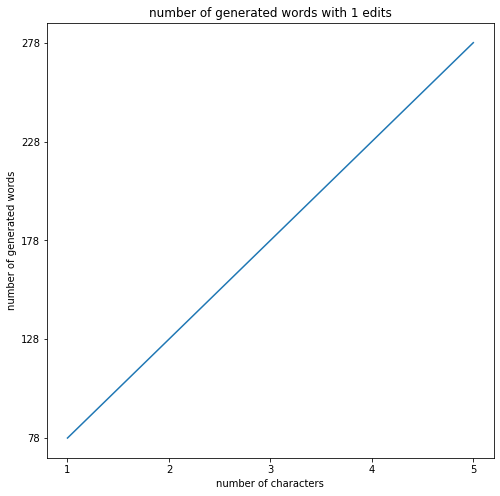

In [258]:
complexity(1)

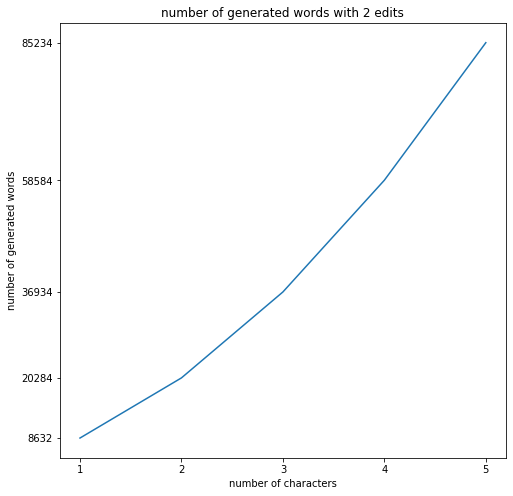

In [259]:
complexity(2)